In [18]:
import gzip
import numpy as np

def images(f):
    with gzip.open(f, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images

def labels(f):
    with gzip.open(f, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [19]:
training_images = images('train-images-idx3-ubyte.gz')
testing_images  = images('t10k-images-idx3-ubyte.gz')
training_labels = labels('train-labels-idx1-ubyte.gz')
testing_labels  = labels('t10k-labels-idx1-ubyte.gz')
print('Train: X=%s, y=%s' % (training_images.shape, training_labels.shape))
print('Test : X=%s, y=%s' % (testing_images.shape, testing_labels.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test : X=(10000, 28, 28), y=(10000,)


In [20]:
from sklearn.model_selection import train_test_split

# Change integers to 32-bit floating point numbers and normalize to range of 0-1
X_train = training_images.astype('float32')/255
X_test  = testing_images.astype('float32')/255

# Splitting the training dataset to train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train, training_labels, stratify=training_labels, test_size=0.2, random_state=42)

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('val  : X=%s, y=%s' % (X_val.shape, y_val.shape))
print('Test : X=%s, y=%s' % (X_test.shape, testing_labels.shape))

Train: X=(48000, 28, 28), y=(48000,)
val  : X=(12000, 28, 28), y=(12000,)
Test : X=(10000, 28, 28), y=(10000,)


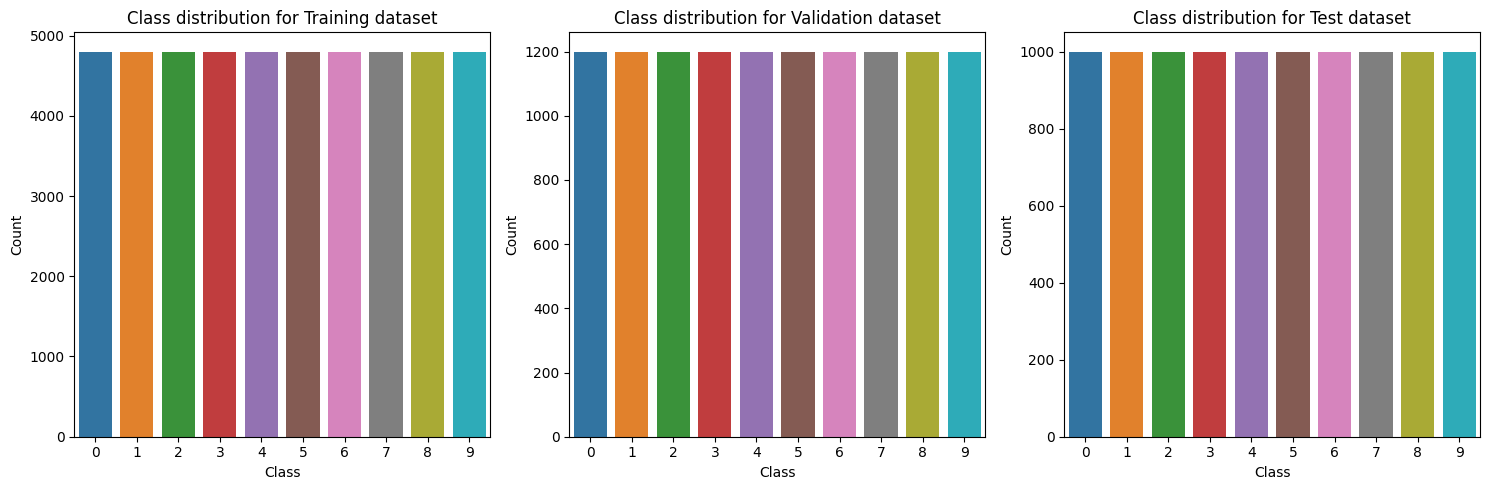

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create separate Series for each dataset
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)
testing_labels_series = pd.Series(testing_labels)

# Calculate value counts for each dataset
class_counts_train = y_train_series.value_counts()
class_counts_val = y_val_series.value_counts()
class_counts_test = testing_labels_series.value_counts()

# Plotting class distributions for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=class_counts_train.index, y=class_counts_train.values)
plt.title("Class distribution for Training dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
sns.barplot(x=class_counts_val.index, y=class_counts_val.values)
plt.title("Class distribution for Validation dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
sns.barplot(x=class_counts_test.index, y=class_counts_test.values)
plt.title("Class distribution for Test dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [22]:
# Flatten the images to 1-D by reshaping
X_train = X_train.reshape(48000,784)
X_val   = X_val.reshape(12000,784)
X_test  = X_test.reshape(10000,784)

print("Training matrix shape  :", X_train.shape)
print("Validation matrix shape:", X_val.shape)
print("Test matrix shape      :", X_test.shape)

Training matrix shape  : (48000, 784)
Validation matrix shape: (12000, 784)
Test matrix shape      : (10000, 784)


In [23]:
from sklearn.decomposition import PCA
pca_all = PCA(n_components = 784)
# Fit on training data
pca_fit = pca_all.fit_transform(X_train)
#percentage variance explained
ratio_variance = np.cumsum(pca_all.explained_variance_ratio_)
pca_fit.shape

(48000, 784)

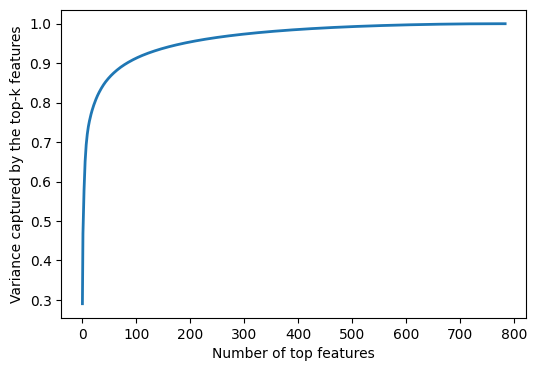

In [24]:
# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(ratio_variance, linewidth=2)
plt.xlabel("Number of top features")
plt.ylabel("Variance captured by the top-k features")
plt.show()

In [25]:
pca = PCA(n_components=0.95)
pca.fit(X_train)
pca.n_components_

187

In [26]:
X_train_t = pca.transform(X_train)
X_val_t   = pca.transform(X_val)
X_test_t  = pca.transform(X_test)

X_train_i = pca.inverse_transform(X_train_t)
X_val_i   = pca.inverse_transform(X_val_t)
X_test_i  = pca.inverse_transform(X_test_t)


training_images         = X_train.reshape(48000,28,28)
reduced_training_images = X_train_i.reshape(48000,28,28)

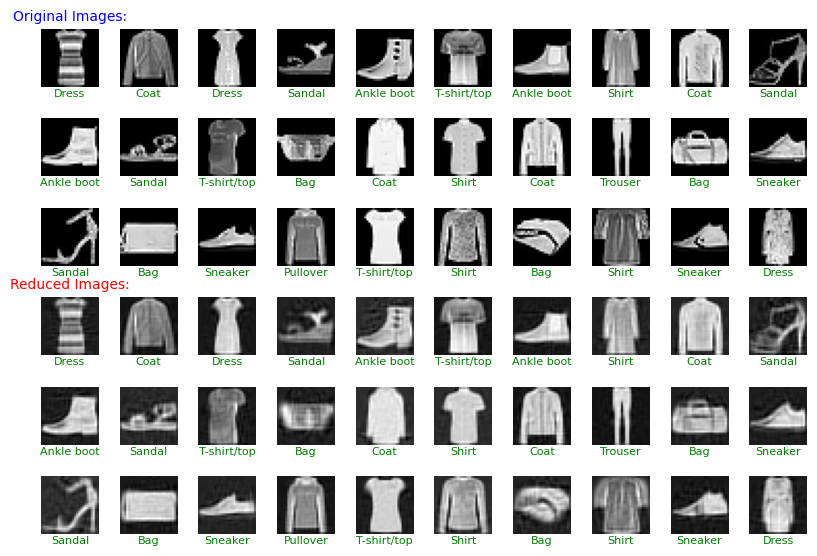

In [27]:
# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Randomly select 30 images from train dataset to visualize
num_images_to_display = 30
random_indexes = np.random.randint(0, X_train.shape[0], num_images_to_display)

# Create a figure with a grid of subplots
plt.figure(figsize=(8, 6))  # Adjust overall figure size

for i, index in enumerate(random_indexes, 1):
    # Original image
    plt.subplot(6, 10, i)
    plt.imshow(training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Original Images:", fontsize=10, color='blue')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

    # Reduced image
    plt.subplot(6, 10, i + num_images_to_display)
    plt.imshow(reduced_training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Reduced Images:", fontsize=10, color='red')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

# Adjust the placement of the title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_train_fnn = torch.tensor(X_train_t).float()
y_train_fnn = torch.tensor(y_train).long()
X_val_fnn   = torch.tensor(X_val_t).float()
y_val_fnn   = torch.tensor(y_val).long()
X_test_fnn  = torch.tensor(X_test_t).float()
y_test_fnn  = torch.tensor(testing_labels).long()

# Creating TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_fnn, y_train_fnn)
val_dataset   = TensorDataset(X_val_fnn, y_val_fnn)
test_dataset  = TensorDataset(X_test_fnn, y_test_fnn)

In [29]:
# Define a FeedForward neural network model
class FNN(nn.Module):
    def __init__(self, nodes_per_layer, activation_function ):
        super().__init__()

        layers = []
        for i in range(len(nodes_per_layer)-2):
            layers.append(nn.Linear(nodes_per_layer[i], nodes_per_layer[i+1]))

            if activation_function == 'relu':
                layers.append(nn.ReLU())
            else:
                layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.Linear(nodes_per_layer[len(nodes_per_layer)-2], nodes_per_layer[len(nodes_per_layer)-1]))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [30]:
# Create a function to train and evaluate the model for a given combination of hyperparameters
def train_and_evaluate(nodes_per_layer, activation_function, optimizer, batch_size, model_count):

    # Create the DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create the model
    model = FNN(nodes_per_layer, activation_function)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters())
    else:
        optimizer = optim.RMSprop(model.parameters())

    # Training loop
    best_val_accuracy = 0.0
    best_val_loss     = 0.0
    best_train_acc    = 0.0
    best_train_loss   = 0.0
    num_epochs        = 30
    train_losses      = []
    val_losses        = []
    train_accuracies  = []
    val_accuracies    = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train_preds += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        train_accuracy = correct_train_preds / len(train_dataset)
        train_accuracies.append(train_accuracy)

        # Evaluate model on Validation dataset
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item() * val_inputs.size(0)

                _, predicted = torch.max(val_outputs, 1)
                correct_val_preds += (predicted == val_labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        val_accuracy = correct_val_preds / len(val_dataset)
        val_accuracies.append(val_accuracy)

        # Save the model on epoch with best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_loss     = epoch_val_loss
            best_train_acc    = train_accuracy
            best_train_loss   = epoch_train_loss
            torch.save(model.state_dict(), 'best_fnn_model'+str(model_count)+'.pth')

    return best_val_accuracy, best_val_loss, best_train_acc,best_train_loss, train_losses, val_losses, train_accuracies, val_accuracies

In [31]:
# Define the hyperparameters to tune
hyperparameters = {
    'nodes_per_layer': [[187,64,10], [187,64,32,10], [187,64,32,16,10]],
    'activation_function': ['relu', 'leaky_relu'],
    'optimizer': ['Adam', 'RMSprop'],
    'batch_size': [32, 64]
}

model_count           = 0
best_val_acc          = 0.0
best_val_loss         = 0.0
best_train_acc        = 0.0
best_train_loss       = 0.0
best_model            = 0
best_train_losses     = []
best_val_losses       = []
best_train_accuracies = []
best_val_accuracies   = []
best_hyperparameters  = {
                            'nodes_per_layer': [187,64,10],
                            'activation_function': 'relu',
                            'optimizer': 'Adam',
                            'batch_size': 32
                        }

# Hyper parameter tuning
for nodes_per_layer in hyperparameters['nodes_per_layer']:
  for activation_function in hyperparameters['activation_function']:
    for optimizer in hyperparameters['optimizer']:
      for batch_size in hyperparameters['batch_size']:
        val_acc, val_loss, train_acc, train_loss, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(nodes_per_layer, activation_function,optimizer, batch_size, model_count)
        if val_acc > best_val_acc:
          best_val_acc                                 = val_acc
          best_val_loss                                = val_loss
          best_train_acc                               = train_acc
          best_train_loss                              = train_loss
          best_hyperparameters['nodes_per_layer']      = nodes_per_layer
          best_hyperparameters['activation_function']  = activation_function
          best_hyperparameters['optimizer']            = optimizer
          best_hyperparameters['batch_size']           = batch_size
          best_train_losses                            = train_losses
          best_val_losses                              = val_losses
          best_train_accuracies                        = train_accuracies
          best_val_accuracies                          = val_accuracies
          print(best_val_acc)
          best_model = model_count
        model_count = model_count + 1

0.8953333333333333


KeyboardInterrupt: ignored

Best hyperparameters: {'nodes_per_layer': [187, 64, 10], 'activation_function': 'relu', 'optimizer': 'Adam', 'batch_size': 32}
Best model path     : best_fnn_model0.pth




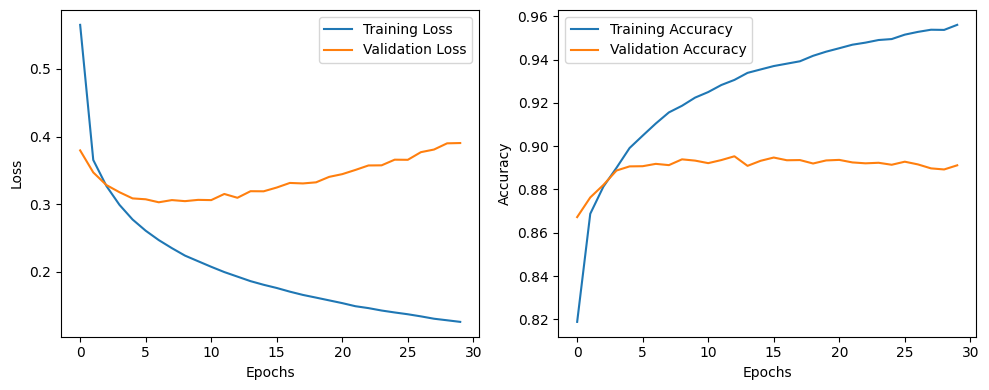

Training loss on best FNN model      : 0.19310494197687755

Training accuracy on best FNN model  : 0.9305833333333333

Validation loss on best FNN model    : 0.3095945356587569

Validation accuracy on best FNN model: 0.8953333333333333



In [32]:

# Print Best hyperparameters
print(f"Best hyperparameters: {best_hyperparameters}")
# Print the best model file path
best_model_path = 'best_fnn_model'+ str(best_model) + '.pth'
print(f"Best model path     : {best_model_path}\n\n")

# Plotting training history for the best FNN model
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label='Training Accuracy')
plt.plot(best_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Print training, validation losses and accuracies on best FNN model

print(f"Training loss on best FNN model      : {best_train_loss}\n")
print(f"Training accuracy on best FNN model  : {best_train_acc}\n")
print(f"Validation loss on best FNN model    : {best_val_loss}\n")
print(f"Validation accuracy on best FNN model: {best_val_acc}\n")


In [33]:
#Evaluation of best model on test dataset

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics


# Initialize your neural network class
model = FNN(best_hyperparameters['nodes_per_layer'], best_hyperparameters['activation_function'])
# Load the saved best model weights
model.load_state_dict(torch.load(best_model_path))

test_loader = DataLoader(test_dataset, batch_size=best_hyperparameters['batch_size'], shuffle=False)

# Set the model to evaluation mode
model.eval()

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate the confusion matrix and accuracy
conf_matrix = confusion_matrix(true_labels, predictions)
print("Classification report for best FNN on test dataset :\n%s\n"
      % (metrics.classification_report(true_labels, predictions)))

print("\nConfusion Matrix on Test dataset:")
print(conf_matrix)

Classification report for best FNN on test dataset :
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.81      0.80      1000
           3       0.86      0.90      0.88      1000
           4       0.81      0.81      0.81      1000
           5       0.96      0.96      0.96      1000
           6       0.70      0.67      0.69      1000
           7       0.94      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Confusion Matrix on Test dataset:
[[834   0  19  30   6   2 100   1   8   0]
 [  4 972   0  18   3   0   3   0   0   0]
 [ 20   1 805  13  92   1  67   0   1   0]
 [ 25   7  11 901  17  